# Fine-tuning BERT for Text Classification through Hybrid Transfer Learning for Natural Language Processing (NLP)

This is an example of a hybrid network constructed using classical-to-quantum transfer learning to fine-tune BERT for text categorization.

Bidirectional Encoder Representations from Transformers is what BERT stands for. It is intended to pre-train deep bidirectional representations from unlabeled text by conditioning on both left and right context. Therefore, the pre-trained BERT model may be fine-tuned with just one extra output layer to generate state-of-the-art models for a variety of NLP applications."
BERT is pre-trained on a massive corpus of unlabeled text, including the whole of Wikipedia (that's 2,500 million words!) and Book Corpus (800 million words).

Now, we will fine-tune a BERT model to classify text using a quantum circuit that has been dressed.
We own an assortment of SMS texts. A portion of these SMS are spam, but the remainder are legitimate. Our mission is to develop a system that can automatically determine whether or not a message is spam.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Dataset

There are two columns in the dataset: label and text. The column "text" holds the message content, whereas "label" is a binary variable where 1 indicates that the message is spam and 0 indicates that it is not spam.

In [3]:
df = pd.read_csv("data/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

This dataset will now be divided into three sets: train, validation, and test.

We will fine-tune the model using the train set and the validation set, and make predictions for the test set.

In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## Import BERT Model and BERT Tokenizer

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Tokenize the Sentences

Since the messages (text) in the dataset are of variable lengths, we will employ padding to ensure that the length of each message is the same. We can pad messages using the maximum sequence length. To determine the correct padding length, we may also examine the distribution of sequence lengths in the train set.

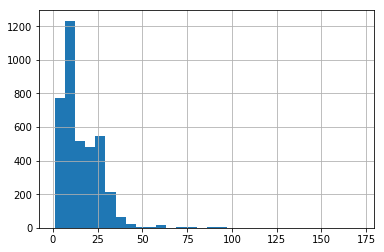

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

It is evident that the majority of the texts include little more than 25 words. In contrast to the maximum length of 175, If we choose 175 as the padding length, then all input sequences will have a length of 175 and the majority of tokens in those sequences will be padding tokens, which will not help the model learn anything useful and will also slow down training.

We will thus set the padding length to 25.

In [9]:
max_seq_len = 25

In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

## convert the integer sequences to tensors.

In [11]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Create DataLoaders

Now, dataloaders will be created for both the train and validation sets. During the training phase, these dataloaders will send batches of train data and validation data to the model as input. 

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Freeze BERT Parameters

We freeze all the layers of the BERT model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.

In [13]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Define Model Architecture Hybrid transfer learning model (classical-to-quantum).

Setting of the main parameters of the network model and of the training process.

In [14]:
n_qubits = 5                     # Number of qubits
q_depth = 4                      # Depth of the quantum circuit (number of variational layers)
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights

Let us initialize a PennyLane device with the default simulator.

In [15]:
dev = qml.device('default.qubit', wires=n_qubits)

First, we define the quantum layers that constitute the quantum circuit.

In [16]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Use the PennyLane `qnode` decorator to define the quantum circuit. The circuit has the conventional structure of a variational quantum circuit:

1. All qubits are started in a balanced superposition of up and down states, then rotated based on the input parameters (local embedding);
2. A series of trainable rotation layers and continual entangling layers are applied in succession. This block does the majority of the computations required to solve the categorization issue.
3. Eventually, the local expectation value of the Z operator is measured for each qubit. This generates a conventional output vector suitable for further post-processing.

In [17]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

Now, we can define a customized `torch.nn.Module` depicting a dressed quantum circuit.
This string is composed of:

1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
4. The quantum circuit described before (`q net`)
5. A classical post-processing layer (`nn.Linear`)

Input to the module is a collection of vectors with 768real parameters (features), and output is a collection of vectors with two real outputs (associated with the two classes of messages: spam and notspam)

In [18]:
class Quantumnet(nn.Module):

  def __init__(self, bert):
      
      super(Quantumnet, self).__init__()

      self.bert = bert

      self.pre_net = nn.Linear(768, n_qubits)
      self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
      self.post_net = nn.Linear(n_qubits, 2)
    
  def forward(self, sent_id, mask):

    _, cls_hs = self.bert(sent_id, attention_mask=mask,  return_dict=False)

    pre_out = self.pre_net(cls_hs) 
    q_in = torch.tanh(pre_out) * np.pi / 2.0 

    # Apply the quantum circuit to each element of the batch and append to q_out
    q_out = torch.Tensor(0, n_qubits)
    q_out = q_out.to(device)
    for elem in q_in:
      q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
      q_out = torch.cat((q_out, q_out_elem))


    return self.post_net(q_out)

In [19]:
# pass the pre-trained BERT to our define architecture
model = Quantumnet(bert)

# push the model to GPU
model = model.to(device)

We will use AdamW as our optimizer. It is an improved version of the Adam optimizer.

In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

## Find Class Weights

Our dataset has an imbalance between classes. The vast majority of messages are not spam. Therefore, we will first calculate class weights for the labels in the train set and then send these weights to the loss function so that the class imbalance is taken care of.

In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = "balanced", 
                                 classes = np.unique(train_labels), 
                                 y = train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [22]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10

## Fine-Tune BERT

So far, we have described the model's architecture, specified the optimizer and loss function, and prepared the dataloaders. Now we must  define a couple of functions to train (fine-tune) and evaluate the model, respectively.

In [23]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [24]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Start Model Training

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.585
Validation Loss: 0.445

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.379
Validation Loss: 0.305

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.299
Validation Loss: 0.228

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.254
Validation Loss: 0.337

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.237
Validation Loss: 0.194

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.224
Validation Loss: 0.305

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.210
Validation Loss: 0.201

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.189
Validat

## Load Saved Model

In [26]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [27]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.82      0.91      0.86       112

   micro avg       0.96      0.96      0.96       836
   macro avg       0.90      0.94      0.92       836
weighted avg       0.96      0.96      0.96       836



In [30]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,701,23
1,10,102
